single leptonJet mass spectrum seems to have two peaks - one around J/Psi (3.1GeV), other around Z (91GeV).
Do a fit to see how close they are.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor

import scipy
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/control_data2018.json'))
datasets = dict(
    A={'files': datasets_['A'], 'treename': 'ffNtuplizer/ffNtuple'},
    B={'files': datasets_['B'], 'treename': 'ffNtuples/ffNtuple'},
    C={'files': datasets_['C'], 'treename': 'ffNtuples/ffNtuple'},
    D={'files': datasets_['D'], 'treename': 'ffNtuples/ffNtuple'},
)

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        masslow_axis = hist.Bin("mass", "mass [GeV]", 50, 0, 10)
        masshigh_axis = hist.Bin("mass", "mass [GeV]", 50, 70, 110)
        
        self._accumulator = processor.dict_accumulator({
            'mass_l': hist.Hist("#counts/0.2GeV", dataset_axis, masslow_axis),
            "mass_h": hist.Hist("#counts/0.8GeV", dataset_axis, masshigh_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ## apply MET filters ##
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        ## data sample already in control region
        output['mass_l'].fill(dataset=dataset, mass=leptonjets.mass.flatten())
        output['mass_h'].fill(dataset=dataset, mass=leptonjets.mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2545/2545 [01:45<00:00, 24.20items/s]


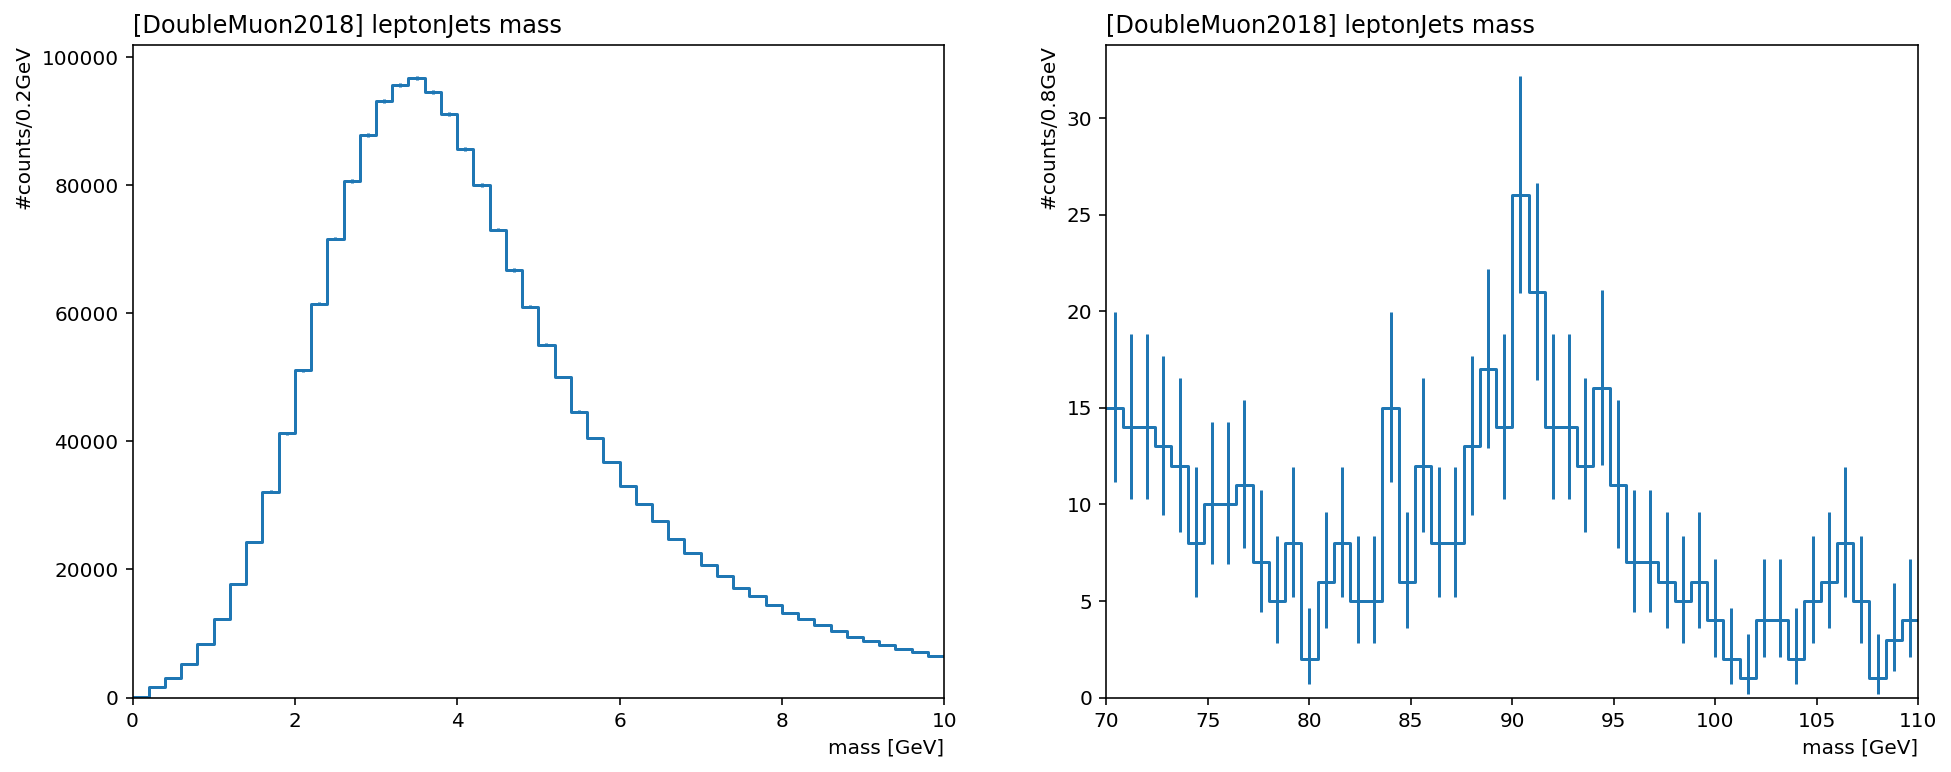

In [5]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))
hist.plot1d(output['mass_l'].project('dataset'), ax=axes[0])
hist.plot1d(output['mass_h'].project('dataset'), ax=axes[1])

for ax in axes:
    ax.set_title('[DoubleMuon2018] leptonJets mass', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [65]:
def crystal_ball(params, x):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
    Note that the definition used here differs slightly. At the time of this
    writing, the wiki article has some discrepancies in definitions/plots. This
    definition makes it easier to fit the function by using complex numbers
    and by negating any negative values for a and n.
    This version of the crystal ball is normalized by an additional parameter.
    params: N, a, n, xb, sig
    """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    try:
        return total.real
    except:
        return total

    
def gaus(params, x):
    """ An un-normalized Gaussian curve.
    params: N, mu, sigma """
    N,mu,sigma = params
    return N*np.exp(-0.5 * ((x-mu)/sigma)**2 )


def expo(params, x):
    """ An exponential curve. *NB* The constant is in the exponent! 
    params: const, slope """
    const, slope = params
    return np.exp(const + slope*x)

def polN_dec(func):
    """ Polynomial decorator """
    degree = int(func.__name__.replace("pol",""))
    def polN(*args):
        params, x = args
        if len(params) != degree+1:
            raise ValueError
        return sum( [param*x**i for i,param in enumerate(params)] )
    polN.__doc__ = \
    """A polynomial function of degree {}. Parameters are provided in
    increasing order of degree, i.e. [0] + [1]*x + [2]*x^2 + ...
    Input: (params, x)
    params - An array of length {}
    x      - The data to evaluate given the previous parameters.
    """
    polN.__doc__ = polN.__doc__.format(degree, degree+1)
    polN.__name__ = "pol{}".format(degree)
    return polN

@polN_dec
def pol0(params,x): return
@polN_dec
def pol1(params,x): return
@polN_dec
def pol2(params,x): return
@polN_dec
def pol3(params,x): return

648.7188301246118 48.238007256706524 21.35701594602723 110.86966712419661 91.41593308682116 3.264807881716565


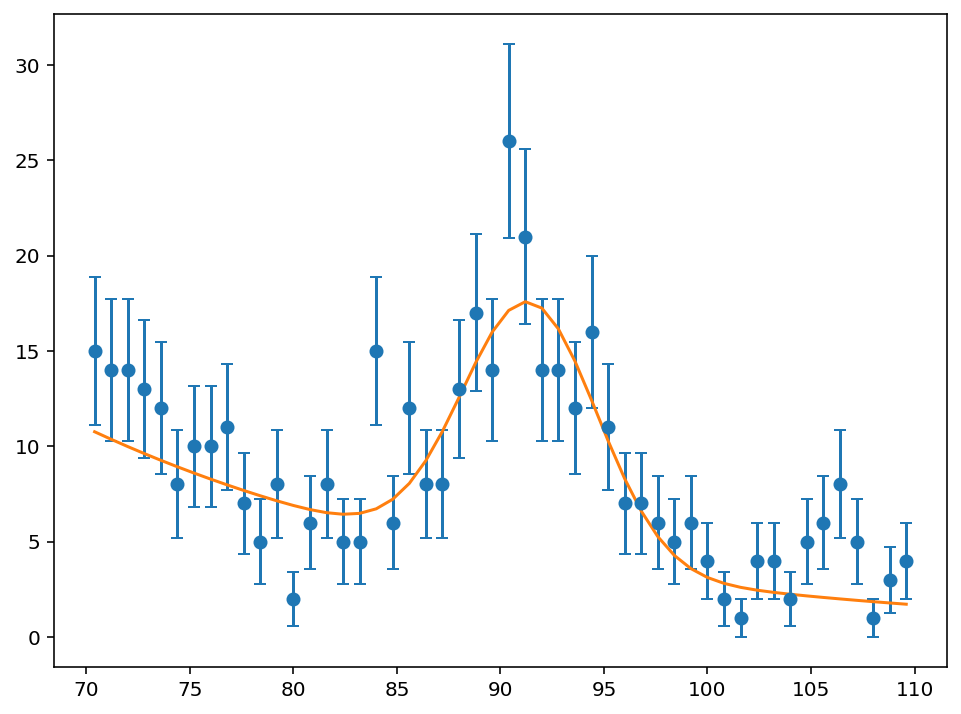

In [57]:
def f(x, a, b, c, d, e, f):
    return a*scipy.stats.expon.pdf(x, b, c) + d*scipy.stats.norm.pdf(x, e, f)
p0=[500, 20, 43, 79, 91, 1.8]

x = output['mass_h'].project('dataset').axis('mass').centers()
y = output['mass_h'].project('dataset').values()[()]
yerr = np.sqrt(y)
parameters, errors = scipy.optimize.curve_fit(f, x, y, sigma=yerr, p0=p0)

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=3)
ax.plot(x, f(x, *parameters));
print(*parameters)

[ 9.40089494e+04 -1.52423317e+01  1.03587803e+02  4.00715788e+00
  1.39310077e+00]


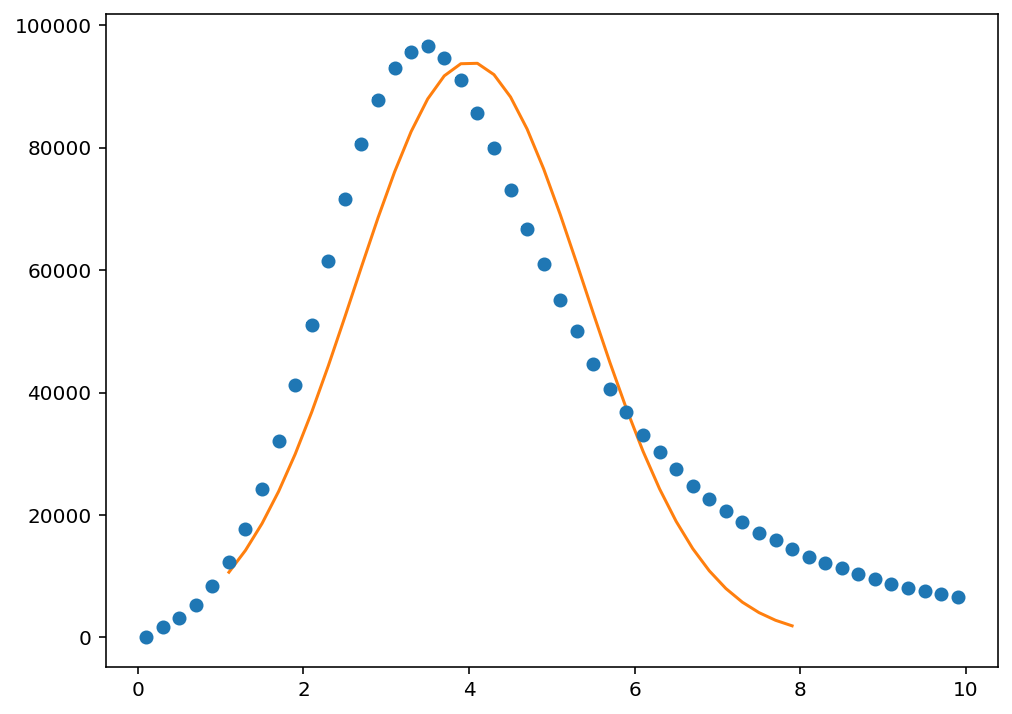

In [77]:
def f(x, N, a, n, xb, sig):
    return crystal_ball((N, a, n, xb, sig), x)

x = output['mass_l'].project('dataset').axis('mass').centers()
y = output['mass_l'].project('dataset').values()[()]
yerr = np.sqrt(y)
msk=(x>1)&(x<8)
parameters, errors = scipy.optimize.curve_fit(f, x, y, sigma=yerr)
print(parameters)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=3)
ax.plot(x[msk], f(x[msk], *parameters));

Dump these histograms into ROOT file..

In [10]:
import uproot
outputfile = uproot.create("leptonjetmass.root")
outputfile['mass_low'] = hist.export1d(output['mass_l'].project('dataset'))
outputfile['mass_high'] = hist.export1d(output['mass_h'].project('dataset'))
outputfile.close()